# An Introduction To Model Calibration With Probly

This notebook is a short introduction to post-processing calibration of neural networks with Probly.

# 0. Motivation and Intuition

A trained neural network might have good accuracy, but that is not all that we could wish for.  
Even if the accuracy of our model is good, it is possible that its confidence does not reflect the true likelyhood of the prediction being correct.

![Model Confidence](https://creatis-myriad.github.io/collections/images/calibration/reliability_histogram.jpg)

As you can see above models can be over or underconfident which means that they either overestimate or underestimate how accurate they are with their predictions.  

But it would be nice to have a good estimate of the accuracy via the confidence, especially in very sensitive areas like medicine or AI assisted driving...

# 1. What is Calibration

This is where calibration - and in this case post-processing calibration - comes in.  
Calibration aims to push the confidence the model gives us to reflect the true accuracy for the inputs. So a perfectly calibrated model would give you a confidence and you would know that is also its accuracy.  

There are two major ways to do calibration on neural networks:
- In-training calibration
- Post-processing calibration

In-training calibration methods would include certain loss functions like focal loss or a regularization method like dropout but we will focus on post-processing calibration since it can be applied to an already trained model withoud the need to modify or retrain it. 

# 2. Calibration with Probly

Probly once again really simplifies the whole process by giving us the `Calibrator` classes for the various frameworks.  
But to look at some calibrations we need something to calibrate in the first place, so lets define a model for that we can use. We will be using torch here, but other frameworks work just the same.

## 2.1 Load the model

We are going to use the pretrained ResNet18 Model from Torchvision for simplicity.

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision.models import ResNet18_Weights
import torchvision.transforms as T
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

net = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
net.fc = nn.Linear(512, 10, device=device)
net = net.to(device)

net_binary = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
net_binary.fc = nn.Linear(512, 1, device=device)
net_binary = net_binary.to(device)

Using device: cpu


## 2.2 Load the data

Firstly, two datasets are loaded: 

- Multi-class classification dataset with 10 classes (CIFAR-10)

In [3]:
transforms = T.Compose([T.ToTensor()])

train = torchvision.datasets.CIFAR10(root="~/datasets", train=True, download=True, transform=transforms)
train, cal = torch.utils.data.random_split(train, [0.8, 0.2])
test = torchvision.datasets.CIFAR10(root="~/datasets", train=False, download=True, transform=transforms)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
cal_loader = DataLoader(cal, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

- Binary classification dataset derived from CIFAR-10, using a single class as the positive class

In [6]:
from collections.abc import Iterable


def binarize_dataset(
    dataset: Iterable[tuple[torch.Tensor, int]],  # an iterable of (image, label)
    positive_class: int,
) -> tuple[torch.Tensor, torch.Tensor]:  # returns (images, labels)
    images = []
    labels = []
    for img, label in dataset:
        images.append(img)
        labels.append(1.0 if label == positive_class else 0.0)
    images = torch.stack(images)  # shape: [N, C, H, W]
    labels = torch.tensor(labels, dtype=torch.float32)
    return images, labels


positive_class = 1
x_train_full, y_train_full = binarize_dataset(train, positive_class)
x_test, y_test = binarize_dataset(test, positive_class)

# Split train
val_size = int(0.2 * len(x_train_full))
train_size = len(x_train_full) - val_size

train_dataset, val_dataset = random_split(
    TensorDataset(x_train_full, y_train_full),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

batch_size = 64

train_loader_binary = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_binary = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_binary = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

## 2.3 Train the model

So let's give the model a quick training session with our datasets.

**Training the multi-class model:**  
In this cell, we train a neural network to classify samples into **10 classes**. We use `CrossEntropyLoss` with the Adam optimizer, and print the running loss to monitor learning progress.


In [4]:
epochs = 5
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()
for epoch in tqdm(range(epochs)):
    net.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Running loss: {running_loss / len(train_loader)}")

 20%|██        | 1/5 [04:22<17:31, 262.85s/it]

Epoch 1, Running loss: 0.9166933582846526


 40%|████      | 2/5 [08:18<12:20, 246.99s/it]

Epoch 2, Running loss: 0.5610507379291924


 60%|██████    | 3/5 [11:21<07:15, 217.73s/it]

Epoch 3, Running loss: 0.42339890056354984


 80%|████████  | 4/5 [15:18<03:45, 225.46s/it]

Epoch 4, Running loss: 0.3315361201003858


100%|██████████| 5/5 [20:01<00:00, 240.21s/it]

Epoch 5, Running loss: 0.24243239935036678


**Training the binary model:**  
Here, we train a neural network for **binary classification**. The model outputs logits and is trained with `BCEWithLogitsLoss` and the Adam optimizer. Targets are converted to floats for compatibility, and the running loss is displayed for tracking training.


In [7]:
epochs = 5
optimizer = optim.Adam(net_binary.parameters())
criterion = nn.BCEWithLogitsLoss()

best_val_loss = float("inf")

for epoch in tqdm(range(epochs)):
    net_binary.train()
    train_loss = 0.0
    for inputs_raw, targets_raw in train_loader_binary:
        inputs = inputs_raw.to(device)
        targets = targets_raw.to(device)

        optimizer.zero_grad()
        outputs = net_binary(inputs).squeeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Running loss: {train_loss / len(train_loader)}")

 20%|██        | 1/5 [04:22<17:29, 262.37s/it]

Epoch 1, Running loss: 0.44118819023322337


 40%|████      | 2/5 [09:18<14:07, 282.34s/it]

Epoch 2, Running loss: 0.2812949931664262


 60%|██████    | 3/5 [14:16<09:38, 289.27s/it]

Epoch 3, Running loss: 0.23019467169347746


 80%|████████  | 4/5 [19:57<05:09, 309.82s/it]

Epoch 4, Running loss: 0.176539396873088


100%|██████████| 5/5 [24:02<00:00, 288.42s/it]

Epoch 5, Running loss: 0.14758670690712655


## 2.4 A quick look at the model

For evaluation purposes probly gives us the function `expected_calibration_error()` to give us an idea of how uncalibrated the model really is.  
Now that we have something to work with, lets take a quick look at the calibration error of the uncalibrated model...

100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Accuracy: 0.7625
Expected Calibration Error: 0.11812844049781564
Brier Score: 0.3606962263584137


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Regular Model'}, xlabel='Confidence', ylabel='Accuracy'>)

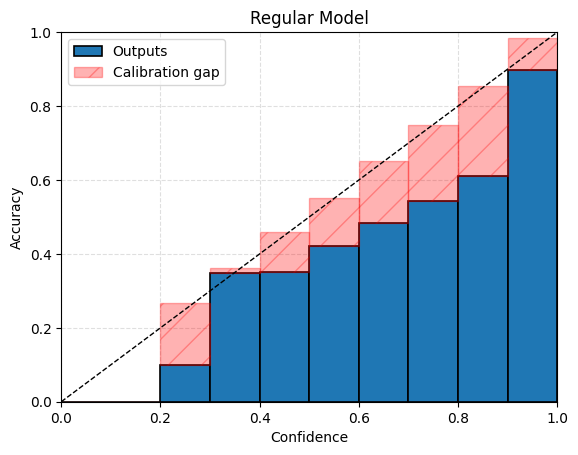

In [9]:
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score, expected_calibration_error, expected_calibration_error_binary

net.eval()
with torch.no_grad():
    outputs = torch.empty(0, device=device)
    targets = torch.empty(0, device=device)
    for inpt, target in tqdm(test_loader):
        outputs = torch.cat((outputs, net(inpt.to(device))), dim=0)
        targets = torch.cat((targets, target.to(device)), dim=0)
outputs = F.softmax(outputs, dim=1)
correct = torch.sum(torch.argmax(outputs, dim=1) == targets).item()
total = targets.size(0)
outputs_np = outputs.cpu().numpy()
targets_np = targets.cpu().numpy().astype(int)
ece = expected_calibration_error(outputs_np, targets_np, num_bins=30)
print(f"Accuracy: {correct / total}")
print(f"Expected Calibration Error: {ece}")

brier_calibrated = brier_score(outputs_np, targets_np)
print(f"Brier Score: {brier_calibrated}")

diagram = compute_reliability_diagram(outputs_np, targets_np)
plot_reliability_diagram(diagram, "Regular Model")

# 3. Histogram Binning

## 3.1 What is Histogram Binning?

Histogram Binning is a simple non-parametric calibration method, where all uncalibrated predictions are divided into mutually exclusive bins. Every bin gets a calibrated score assigned, so that if a prediction falls into bin A for example, the prediction would be "calibrated" to the calibrated score of bin A.

## 3.2 Histogram Binning with Probly

#### Here's how we can implement Histogram Binning with probly

This code performs histogram binning calibration on a **binary** classification model. 

It first collects predicted probabilities and true labels from a validation dataset to fit a histogram binning calibrator, which partitions the probability space into bins and learns to adjust confidence estimates within each bin. 

The calibrated model probabilities are then computed on a separate test set, and the calibration quality is evaluated by computing the Expected Calibration Error (ECE) both before and after calibration.

In [10]:
from probly.calibration.histogram_binning.torch import HistogramBinning

net_binary.eval()
val_probs_list = []
val_targets_list = []
with torch.no_grad():
    for inputs, targets in val_loader_binary:
        logits = net_binary(inputs.to(device)).squeeze(1)
        probs = torch.sigmoid(logits)
        val_probs_list.append(probs.cpu())
        val_targets_list.append(targets.cpu())

val_probs = torch.cat(val_probs_list)
val_targets = torch.cat(val_targets_list).long()

calibrator = HistogramBinning(n_bins=10)
calibrator.fit(val_probs, val_targets)

# Evaluate on test set
all_targets = []
all_probs = []
all_probs_before = []
net_binary.eval()
with torch.no_grad():
    for inpt, target in test_loader_binary:
        logits = net_binary(inpt.to(device)).squeeze(1)
        probs = torch.sigmoid(logits)
        all_probs_before.append(probs.cpu())

        all_probs.append(calibrator.predict(probs.cpu()))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.numpy()
all_targets_np = all_targets.numpy()

ece_before = expected_calibration_error_binary(all_probs_before_np, all_targets_np)
ece_after = expected_calibration_error_binary(all_probs_np, all_targets_np)


print(f"Expected Calibration Error before Histogram Binning calibration: {ece_before}")
print(f"Expected Calibration Error after Histogram Binning calibration: {ece_after}")

Expected Calibration Error before Histogram Binning calibration: 0.027268595212697984
Expected Calibration Error after Histogram Binning calibration: 0.005874190133810058


# 4. Temperature Scaling

## 4.1 What is Temperature Scaling?

Temperature scaling is a simple way to make a model’s confidence more honest. Many machine learning models, especially neural networks, are good at predicting the right class but tend to be too confident about their answers. Temperature scaling fixes this by slightly adjusting the model’s output probabilities after training. It does this by dividing the model’s raw scores by a value called the temperature, which can make the probabilities softer and less extreme. A higher temperature makes the model more cautious, while a lower one makes it more confident. The best temperature is learned using a validation set. Importantly, this process doesn’t change what the model predicts—it only makes the confidence behind those predictions more realistic and easier to trust.

## 4.2 Temperature Scaling with Probly

This code applies temperature scaling to calibrate a neural network’s predicted probabilities by learning a temperature parameter on a separate calibration dataset while keeping the model weights fixed. After calibration, the model generates probability predictions on the test set, which are then evaluated using Expected Calibration Error (ECE) to measure the gap between confidence and accuracy, and the Brier Score to assess overall probabilistic accuracy. Finally, a reliability diagram is plotted to visually show how well the model’s predicted confidence aligns with actual performance, where predictions closer to the diagonal indicate better calibration.

In [ ]:
from probly.calibration.plattvectortemperature.common import temperature
from probly.calibration.visualization.reliability_diagram import compute_reliability_diagram, plot_reliability_diagram
from probly.evaluation.metrics import brier_score

model = temperature(net)
model.fit(cal_loader, learning_rate=0.01, max_iter=100)

all_targets = []
all_probs = []
all_probs_before = []
net.eval()
with torch.no_grad():
    for inpt, target in test_loader:
        logits = net(inpt.to(device))
        probs = torch.softmax(logits, dim=1)
        all_probs_before.append(probs.cpu())

        all_probs.append(model.predict(inpt))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)
all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.detach().cpu().numpy()
all_targets_np = all_targets.detach().cpu().numpy()

ece_calibrated = expected_calibration_error(all_probs_np, all_targets_np, num_bins=10)
print(f"Expected Calibration Error, after Temperature Scaling: {ece_calibrated}")

brier_calibrated = brier_score(all_probs_np, all_targets_np)
print(f"Brier Score, after Temperature Scaling: {brier_calibrated}")

diagram = compute_reliability_diagram(all_probs_np, all_targets_np)
plot_reliability_diagram(diagram, "Temperature Scaling")
diagram_before = compute_reliability_diagram(all_probs_before_np, all_targets_np)

# 5. Platt Scaling

## 5.1 What is Platt Scaling?

Platt scaling is a probability calibration technique used in machine learning to transform a classifier’s raw output scores into well-calibrated probability estimates for binary classification problems. It fits a logistic (sigmoid) function to the model’s predictions using a separate validation dataset, learning parameters that align predicted probabilities with observed class frequencies. This approach is commonly applied to models such as Support Vector Machines, which produce decision scores that are effective for ranking but not directly interpretable as probabilities.

## 5.2 Plat Scaling with Probly

This code applies TorchAffine calibration to the binary model. The calibration is fitted on the validation set, and we collect predicted probabilities before and after calibration on the test set. Probabilities and true labels are stored as NumPy arrays for ECE evaluation.

In [ ]:
from probly.calibration.plattvectortemperature.common import affine

model = affine(net_binary, 1)
model.fit(val_loader_binary)

all_targets = []
all_probs = []
all_probs_before = []
net_binary.eval()
with torch.no_grad():
    for inpt, target in test_loader_binary:
        logits = net_binary(inpt.to(device))
        probs = torch.sigmoid(logits)
        all_probs_before.append(probs.cpu())

        all_probs.append(model.predict(inpt))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.detach().cpu().numpy()
all_targets_np = all_targets.detach().cpu().numpy()

ece_before = expected_calibration_error_binary(all_probs_before_np, all_targets_np)
ece_after = expected_calibration_error_binary(all_probs_np, all_targets_np)

print(f"Expected Calibration Error before Platt Scaling calibration: {ece_before}")
print(f"Expected Calibration Error after Platt Scaling calibration: {ece_after}")

# 6. Vector Scaling

## 6.1 What is Vector Scaling?

Vector Scaling is an extension of Platt scaling for multi-class problems. It applies a learned scale and bias to each class’s logits, improving calibration so the predicted probabilities better match the true class frequencies.

## 6.2 Vector Scaling with Probly

In [ ]:
from probly.calibration.plattvectortemperature.common import affine

model = affine(net, 10)
model.fit(cal_loader)

all_targets = []
all_probs = []
all_probs_before = []
net.eval()
with torch.no_grad():
    for inpt, target in test_loader:
        logits = net(inpt.to(device))
        probs = torch.sigmoid(logits)
        all_probs_before.append(probs.cpu())

        all_probs.append(model.predict(inpt))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.detach().cpu().numpy()
all_targets_np = all_targets.detach().cpu().numpy()

ece_calibrated = expected_calibration_error(all_probs_np, all_targets_np, num_bins=10)
print(f"Expected Calibration Error, after Temperature Scaling: {ece_calibrated}")

brier_calibrated = brier_score(all_probs_np, all_targets_np)
print(f"Brier Score, after Temperature Scaling: {brier_calibrated}")

diagram_vector = compute_reliability_diagram(all_probs_np, all_targets_np)
plot_reliability_diagram(diagram_vector, "Vector Scaling")

# 7. Isotonic Regression

## 7.1 What is Isotonic Regression?

Isotonic Regression is one of the most common non-parametric post-processing calibration methods. It learns a piecewise constant function to transform uncalibrated model outputs and aims to minimize the square loss.  
It can be seen as a strict generalization of histogram binning.

## 7.2 Isotonic Regression with Probly

Let's calibrate our base model with probly's isotonic regression and again, compare it to the base model.

In [ ]:
from probly.calibration.isotonic_regression.common import isotonic_regression

isotonic_regression_cal = isotonic_regression(net, use_logits=False)
isotonic_regression_cal.fit(cal_loader)

cal_probs_isotonic = []
labels_isotonic = []
with torch.no_grad():
    for x_to_device, y in test_loader:
        x = x_to_device.to(device)
        p = isotonic_regression_cal.predict(x)
        cal_probs_isotonic.append(p.cpu())
        labels_isotonic.append(y.cpu())

cal_probs_isotonic = torch.cat(cal_probs_isotonic).numpy()
all_labels_isotonic = torch.cat(labels_isotonic).numpy()

ece_calibrated_isotonic = expected_calibration_error(cal_probs_isotonic, all_labels_isotonic)
print(f"Expected Calibration Error after Isotonic Regression: {ece_calibrated_isotonic}")

brier_calibrated_isotonic = brier_score(cal_probs_isotonic, all_labels_isotonic)
print(f"Brier Score after Isotonic Regression: {brier_calibrated_isotonic}")

diagram_isotonic = compute_reliability_diagram(cal_probs_isotonic, all_labels_isotonic)
plot_reliability_diagram(diagram_isotonic, "Isotonic Regression")

As we can see, the isotonic regression calibrated the models outputs and the brier score should have decreased. The ECE might not necessarily decrease since isotonic regression can over fit and thus slightly increase the ECE.

# 8. Bayesian Binning into Quantiles (BBQ)

## 8.1 What is BBQ?

Bayesian Binning Quantiles is an advanced non-parametric calibration method that improves upon simple histogram binning, by curbing its biggest weakness - **the result of calibration is heavily dependant on the initial choice of the number of bins.** 

Bayesian Binning solves this by trying many different ways of binning, up to an arbitrary number of bins, and averages by doing Bayesian averaging. After that it assigns **a score (a kind of likelihood)** to each bin amount, based on how well it fits the calibration data. Finally, it combines the predictions from all these binnings, weighting each by its score, to produce a more reliable calibrated output.

## 8.2 BBQ with Probly

#### Here's how we can implement BBQ Calibration with probly

This code performs BBQ calibration on a **binary** classification model. 

It first collects predicted probabilities and true labels from a validation dataset to fit a Bayesian binning calibrator, which considers multiple binning schemes **(from 2 to max_bins)** and uses Bayesian model averaging to weight each scheme according to its marginal likelihood.

The calibrated model probabilities are then computed on a separate test set, and the calibration quality is evaluated by computing the Expected Calibration Error (ECE) both before and after calibration.

In [11]:
from probly.calibration.bayesian_binning.torch import BayesianBinningQuantiles
from probly.evaluation.metrics import expected_calibration_error_binary

# Fit the calibrator on validation set
net_binary.eval()
val_probs_list = []
val_targets_list = []
with torch.no_grad():
    for inputs, targets in val_loader_binary:
        logits = net_binary(inputs.to(device)).squeeze(1)
        probs = torch.sigmoid(logits)
        val_probs_list.append(probs.cpu())
        val_targets_list.append(targets.cpu())

val_probs = torch.cat(val_probs_list)
val_targets = torch.cat(val_targets_list).long()

calibrator = BayesianBinningQuantiles(max_bins=10)
calibrator.fit(val_probs, val_targets)

# Evaluate on test set
all_targets = []
all_probs = []
all_probs_before = []
net_binary.eval()
with torch.no_grad():
    for inpt, target in test_loader_binary:
        logits = net_binary(inpt.to(device)).squeeze(1)
        probs = torch.sigmoid(logits)
        all_probs_before.append(probs.cpu())

        all_probs.append(calibrator.predict(probs.cpu()))
        all_targets.append(target)

all_probs_before = torch.cat(all_probs_before)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

all_probs_before_np = all_probs_before.numpy()
all_probs_np = all_probs.numpy()
all_targets_np = all_targets.numpy()

ece_before = expected_calibration_error_binary(all_probs_before_np, all_targets_np)
ece_after = expected_calibration_error_binary(all_probs_np, all_targets_np)

print(f"Expected Calibration Error before BBQ calibration: {ece_before:.4f}")
print(f"Expected Calibration Error after BBQ calibration: {ece_after:.4f}")

Expected Calibration Error before BBQ calibration: 0.0273
Expected Calibration Error after BBQ calibration: 0.0025
